# Stanford CME 241 (Winter 2024) - Assignment 7

**Due: Mar 4 @ 11:59pm Pacific Time on Gradescope (after the exam).**

Assignment instructions:
- **Solve all 3 questions.**
- Empty code blocks are for your use. Feel free to create more under each section as needed.

Submission instructions:
- When complete, fill out your publicly available GitHub repo file URL and group members below, then export or print this .ipynb file to PDF and upload the PDF to Gradescope.

*Link to this ipynb file in your public GitHub repo (replace below URL with yours):* 

https://github.com/sanj909/cme241/blob/master/assignments/assignment7.ipynb

*Group members (replace below names with people in your group):* 
- Sanjit Neelam
- Ryan Padnis

## Imports

In [1]:
import itertools
from itertools import islice
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
from typing import Callable, Dict, Iterable, Iterator, Mapping, Tuple, TypeVar

from rl.approximate_dynamic_programming import ValueFunctionApprox, extended_vf
from rl.chapter2.simple_inventory_mrp import (
    SimpleInventoryMRPFinite, InventoryState)
from rl.chapter10.random_walk_mrp import RandomWalkMRP
from rl.chapter10.prediction_utils import (
    unit_experiences_from_episodes, compare_td_and_mc)
from rl.distribution import Choose, Categorical
import rl.iterate as iterate
from rl.iterate import last
from rl.function_approx import learning_rate_schedule, Tabular, Gradient
import rl.markov_process as mp
from rl.markov_process import TransitionStep, NonTerminal
from rl.monte_carlo import mc_prediction
import rl.td as td

## Question 1
In the following question, we explore the connection between TD and MC
algorithms.

1.  Implement the TD($\lambda$) Prediction algorithm from scratch in
    Python code. First do it for the Tabular case, then do it for the
    case of Function Approximation.

2.  Prove that the MC Error can be written as the sum of discounted TD
    errors, i.e.,
    $$G_t - V(S_t) = \sum_{u=t}^{T-1} \gamma^{u-t} \cdot (R_{u+1} + \gamma \cdot V(S_{u+1}) - V(S_u))$$
    The goal here is for you to practice formal proof-writing of these
    types of simple yet important identities. So aim to work this out
    from scratch rather than treating this as a special case of a more
    general result proved in class or in the textbook.

3.  Test your above implementation of TD($\lambda$) Prediction algorithm
    by comparing the Value Function of an MRP you have previously
    developed (or worked with) as obtained by Policy Evaluation (DP)
    algorithm, as obtained by MC, as obtained by TD, and as obtained by
    your TD($\lambda$) implementation. Plot graphs of convergence for
    different values of $\lambda$.

4.  Extend `RandomWalkMRP` (in
    [rl/chapter10/random_walk_mrp.py](https://github.com/TikhonJelvis/RL-book/blob/master/rl/chapter10/random_walk_mrp.py))
    to `RandomWalkMRP2D` which is a random walk in 2-D with states
    $\{i, j) | 0 \leq i \leq B_1, 0 \leq j \leq B_2\}$ with terminal
    states as $(0, j)$ and $(B_1, j)$ for all $j$, $(i, 0)$ and
    $(i, B_2)$ for all $i$, and with reward of 0 for all $(0, j)$ and
    for all $(i, 0)$, reward of 1 for all $(B_1, j)$ and for all
    $(i, B_2)$, and with discrete probabilities of 4 movements - UP,
    DOWN, LEFT, RIGHT from any non-terminal state. Analyze the
    convergence of MC and TD on this `RandomWalkMRP2D` much like how we
    analyzed it for `RandomWalkMRP`, along with plots of similar graphs.

### 1.

In [2]:
S = TypeVar('S')
V = Mapping[NonTerminal[S], float]

In [3]:
def tabular_td_lambda_prediction(
    transitions: Iterable[mp.TransitionStep[S]],
    vf: V[S],
    gamma: float,
    lambd: float,
    alpha: float,
    H: int,
    beta: float
) -> Iterator[V[S]]:
    '''Evaluate an MRP using TD(lambda) using the given sequence of
    transitions.

    Each value this function yields represents the exact value function 
    for the MRP after an additional transition.
    '''
    # Track the number of times each state has been updated
    tu = {s: 1 for s in vf.keys()}
    # Initialize the eligibility trace for each state
    et = {s: 0 for s in vf.keys()}

    def step(
            v: V[S],
            transition: mp.TransitionStep[S]
    ) -> V[S]:
        s, r = transition.state, transition.reward
        delta = r + gamma * v[transition.next_state] - v[s]
        alpha_n = alpha / (1 + ((tu[s] - 1) / H) ** beta) # 11.11 in textbook
        nonlocal et
        et = {s: lambd * gamma * e for s, e in et.items()}
        et[s] += 1
        v[s] += alpha_n * delta * et[s]
        tu[s] += 1
        return v
    return iterate.accumulate(transitions, step, initial=vf)

In [4]:
def td_lambda_prediction(
        transitions: Iterable[mp.TransitionStep[S]],
        approx_0: ValueFunctionApprox[S],
        gamma: float,
        lambd: float
) -> Iterator[ValueFunctionApprox[S]]:
    '''Evaluate an MRP using TD(lambda) using the given sequence of transitions.

    Each value this function yields represents the approximated value function
    for the MRP after an additional transition.
    '''
    # Initialize the eligibility trace for each state
    et: Gradient[ValueFunctionApprox[S]] = Gradient(approx_0).zero()

    def step(
            v: ValueFunctionApprox[S],
            transition: mp.TransitionStep[S]   
    ) -> ValueFunctionApprox[S]:
        s, r = transition.state, transition.reward
        td_target = r + gamma * extended_vf(v, transition.next_state)
        nonlocal et
        et = et * (gamma * lambd) + v.objective_gradient(
            xy_vals_seq=[(s, td_target)],
            obj_deriv_out_fun=lambda x1, y1: np.ones(len(x1))
        )
        return v.update_with_gradient(
            et * (v(s) - td_target)
        )
    return iterate.accumulate(transitions, step, initial=approx_0)

### 2.

We have
\begin{align*}
    \sum_{u=t}^{T-1} \gamma^{u-t} \cdot (R_{u+1} + \gamma \cdot V(S_{u+1}) - V(S_u)) &= \left( \sum_{u=t}^{T-1} \gamma^{u-t} R_{u+1} \right) + \left( \sum_{u=t}^{T-1} \gamma^{u-t+1} V(S_{u+1}) - \gamma^{u-t} V(S_u) \right)  \\
    &= G_t + \gamma^{-t} \left( \sum_{u=t}^{T-1} \gamma^{u+1} V(S_{u+1}) - \gamma^{u} V(S_u) \right) \\
    &= G_t + \gamma^{-t} \left( \gamma^{T} V(S_{T}) - \gamma^{t} V(S_t) \right) \\
    &= G_t - V(S_t), \\
\end{align*}
where we used the fact that $V(S_T) = 0$ since the expected return from a terminal state is zero.

### 3.

In [5]:
user_capacity = 2
user_poisson_lambda = 1.0
user_holding_cost = 1.0
user_stockout_cost = 10.0

si_mrp = SimpleInventoryMRPFinite(
    capacity=user_capacity,
    poisson_lambda=user_poisson_lambda,
    holding_cost=user_holding_cost,
    stockout_cost=user_stockout_cost
)
traces: Iterable[Iterable[TransitionStep[InventoryState]]] = \
    si_mrp.reward_traces(Choose(si_mrp.non_terminal_states))

#### Policy Evaluation (DP)

In [6]:
user_gamma = 0.9

print('Exact Value Function (DP)')
si_mrp.display_value_function(gamma=user_gamma)

Exact Value Function (DP)
{NonTerminal(state=InventoryState(on_hand=0, on_order=2)): -37.329,
 NonTerminal(state=InventoryState(on_hand=1, on_order=1)): -38.329,
 NonTerminal(state=InventoryState(on_hand=1, on_order=0)): -38.971,
 NonTerminal(state=InventoryState(on_hand=2, on_order=0)): -39.329,
 NonTerminal(state=InventoryState(on_hand=0, on_order=1)): -37.971,
 NonTerminal(state=InventoryState(on_hand=0, on_order=0)): -43.596}


#### MC Prediction

In [7]:
print('\nMC Prediction (FunctionApprox)')
it: Iterator[ValueFunctionApprox[InventoryState]] = mc_prediction(
    traces=traces,
    approx_0=Tabular(),
    γ=user_gamma,
    episode_length_tolerance=1e-6
)
num_traces = 1000
last_func: ValueFunctionApprox[InventoryState] = last(islice(it, num_traces))
pprint({s: round(last_func.evaluate([s])[0], 3) 
        for s in si_mrp.non_terminal_states})


MC Prediction (FunctionApprox)
{NonTerminal(state=InventoryState(on_hand=0, on_order=2)): -37.36,
 NonTerminal(state=InventoryState(on_hand=1, on_order=1)): -38.358,
 NonTerminal(state=InventoryState(on_hand=1, on_order=0)): -38.971,
 NonTerminal(state=InventoryState(on_hand=2, on_order=0)): -39.418,
 NonTerminal(state=InventoryState(on_hand=0, on_order=1)): -37.907,
 NonTerminal(state=InventoryState(on_hand=0, on_order=0)): -43.608}


#### TD Prediction

In [8]:
episode_length: int = 100
initial_learning_rate: float = 0.03
half_life: float = 1000.0
exponent: float = 0.5

td_experiences: Iterable[TransitionStep[InventoryState]] = \
    unit_experiences_from_episodes(
        traces,
        episode_length
    )
learning_rate_func: Callable[[int], float] = learning_rate_schedule(
    initial_learning_rate=initial_learning_rate,
    half_life=half_life,
    exponent=exponent
)

In [9]:
print('TD Prediction (FunctionApprox)')
td_vfs: Iterator[ValueFunctionApprox[InventoryState]] = td.td_prediction(
    transitions=td_experiences,
    approx_0=Tabular(count_to_weight_func=learning_rate_func),
    γ=user_gamma
)
num_episodes = 10000
final_td_vf: ValueFunctionApprox[InventoryState] = \
    iterate.last(itertools.islice(td_vfs, episode_length * num_episodes))
pprint({s: round(final_td_vf(s), 3) for s in si_mrp.non_terminal_states})

TD Prediction (FunctionApprox)
{NonTerminal(state=InventoryState(on_hand=0, on_order=2)): -37.532,
 NonTerminal(state=InventoryState(on_hand=1, on_order=1)): -38.323,
 NonTerminal(state=InventoryState(on_hand=1, on_order=0)): -38.952,
 NonTerminal(state=InventoryState(on_hand=2, on_order=0)): -39.516,
 NonTerminal(state=InventoryState(on_hand=0, on_order=1)): -38.032,
 NonTerminal(state=InventoryState(on_hand=0, on_order=0)): -43.775}


#### TD($\lambda$) Prediction

In [10]:
print('Tabular TD(\lambda) Prediction (Ours)')
td_vfs: Iterator[V[InventoryState]] = tabular_td_lambda_prediction(
    transitions=td_experiences,
    vf={s: 0.0 for s in si_mrp.non_terminal_states},
    gamma=user_gamma,
    lambd=0.9,
    alpha=initial_learning_rate,
    H=episode_length,
    beta=exponent
)
num_episodes = 10000
final_td_vf: V[InventoryState] = \
    iterate.last(itertools.islice(td_vfs, episode_length * num_episodes))
pprint({s: round(final_td_vf[s], 3) for s in si_mrp.non_terminal_states})

Tabular TD(\lambda) Prediction (Ours)
{NonTerminal(state=InventoryState(on_hand=0, on_order=2)): -37.185,
 NonTerminal(state=InventoryState(on_hand=1, on_order=1)): -38.253,
 NonTerminal(state=InventoryState(on_hand=1, on_order=0)): -38.825,
 NonTerminal(state=InventoryState(on_hand=2, on_order=0)): -39.196,
 NonTerminal(state=InventoryState(on_hand=0, on_order=1)): -38.018,
 NonTerminal(state=InventoryState(on_hand=0, on_order=0)): -43.497}


In [11]:
print('TD(\lambda) Prediction with Function Approximation (Ours)')
td_vfs: Iterator[V[InventoryState]] = td_lambda_prediction(
    transitions=td_experiences,
    approx_0=Tabular(count_to_weight_func=learning_rate_func),
    gamma=user_gamma,
    lambd=0.9
)
num_episodes = 10000
final_td_vf: V[InventoryState] = \
    iterate.last(itertools.islice(td_vfs, episode_length * num_episodes))
pprint({s: round(final_td_vf.evaluate([s])[0], 3) 
        for s in si_mrp.non_terminal_states})

TD(\lambda) Prediction with Function Approximation (Ours)
{NonTerminal(state=InventoryState(on_hand=0, on_order=2)): -37.478,
 NonTerminal(state=InventoryState(on_hand=1, on_order=1)): -38.306,
 NonTerminal(state=InventoryState(on_hand=1, on_order=0)): -39.035,
 NonTerminal(state=InventoryState(on_hand=2, on_order=0)): -39.834,
 NonTerminal(state=InventoryState(on_hand=0, on_order=1)): -38.092,
 NonTerminal(state=InventoryState(on_hand=0, on_order=0)): -43.742}


#### Graphs of convergence for different values of $\lambda$

In [12]:
true_vf = {
    (si_mrp.non_terminal_states[i].state.on_hand, si_mrp.non_terminal_states[i].state.on_order): v
    for i, v in enumerate(si_mrp.get_value_function_vec(user_gamma))
}

In [13]:
convergence_results = {}
for lambd in np.linspace(0, 1, 6):
    td_vfs: Iterator[V[InventoryState]] = tabular_td_lambda_prediction(
        transitions=td_experiences,
        vf={s: 0.0 for s in si_mrp.non_terminal_states},
        gamma=user_gamma,
        lambd=lambd,
        alpha=initial_learning_rate,
        H=episode_length,
        beta=exponent
    )
    num_episodes = 1000
    rmses = []
    for i in range(episode_length * num_episodes):
        td_vf = next(td_vfs)
        if i % episode_length == 0:
            td_vf = {(s.state.on_hand, s.state.on_order): v for s, v in td_vf.items()}
            errors = {s: abs(td_vf[s] - true_vf[s]) for s in td_vf.keys()}
            rmse = np.sqrt(np.mean(list(errors.values())))
            rmses.append(rmse)
    convergence_results[lambd] = rmses

In [14]:
td_vfs: Iterator[ValueFunctionApprox[InventoryState]] = td.td_prediction(
    transitions=td_experiences,
    approx_0=Tabular(count_to_weight_func=learning_rate_func),
    γ=user_gamma
)
td_rmses = []
for i in range(episode_length * num_episodes):
    td_vf = next(td_vfs)   
    if i % episode_length == 0:
        td_vf = {(s.state.on_hand, s.state.on_order): v for s, v in td_vf.values_map.items()}
        errors = {s: abs(td_vf[s] - true_vf[s]) for s in td_vf.keys()}
        rmse = np.sqrt(np.mean(list(errors.values())))
        td_rmses.append(rmse)

/Users/sanjitneelam/miniconda3/envs/cme241/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/sanjitneelam/miniconda3/envs/cme241/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [15]:
it: Iterator[ValueFunctionApprox[InventoryState]] = mc_prediction(
    traces=traces,
    approx_0=Tabular(),
    γ=user_gamma,
    episode_length_tolerance=1e-6
)
mc_rmses = []
for i in range(num_episodes):
    mc_vf = next(it)
    mc_vf = {(s.state.on_hand, s.state.on_order): v for s, v in mc_vf.values_map.items()}
    errors = {s: abs(mc_vf[s] - true_vf[s]) for s in mc_vf.keys()}
    rmse = np.sqrt(np.mean(list(errors.values())))
    mc_rmses.append(rmse)

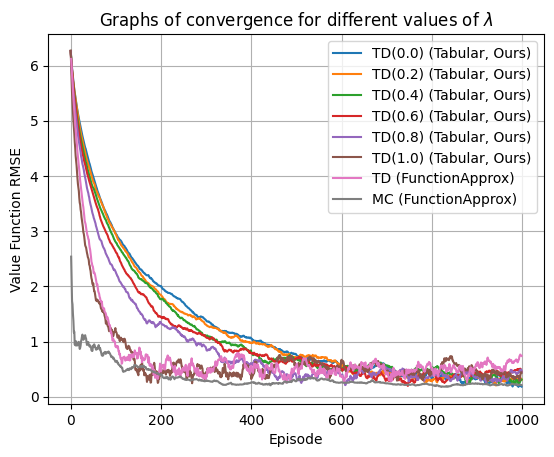

In [16]:
for lambd, rmses in convergence_results.items():
    plt.plot(rmses, label=f'TD({round(lambd, 1)}) (Tabular, Ours)')
plt.plot(td_rmses, label='TD (FunctionApprox)')
plt.plot(mc_rmses, label='MC (FunctionApprox)')

plt.xlabel('Episode');
plt.ylabel('Value Function RMSE');
plt.grid(True);
plt.title('Graphs of convergence for different values of $\lambda$')
plt.legend();
plt.show()

For this problem and for the hyperparameters we have chosen, MC converges faster than TD and MC has lower variance than TD. Similarly, the convergence properties of TD($\lambda$) for larger values of $\lambda$ are better than the convergence properties of TD for smaller values of $\lambda$.

### 4.

Extend `RandomWalkMRP` (in
    [rl/chapter10/random_walk_mrp.py](https://github.com/TikhonJelvis/RL-book/blob/master/rl/chapter10/random_walk_mrp.py))
    to `RandomWalkMRP2D` which is a random walk in 2-D with states
    $\{i, j) | 0 \leq i \leq B_1, 0 \leq j \leq B_2\}$ with terminal
    states as $(0, j)$ and $(B_1, j)$ for all $j$, $(i, 0)$ and
    $(i, B_2)$ for all $i$, and with reward of 0 for all $(0, j)$ and
    for all $(i, 0)$, reward of 1 for all $(B_1, j)$ and for all
    $(i, B_2)$, and with discrete probabilities of 4 movements - UP,
    DOWN, LEFT, RIGHT from any non-terminal state. Analyze the
    convergence of MC and TD on this `RandomWalkMRP2D` much like how we
    analyzed it for `RandomWalkMRP`, along with plots of similar graphs.

In [17]:
class RandomWalkMRP2D(mp.FiniteMarkovRewardProcess[Tuple[int, int]]):
    B_1: int
    B_2: int
    p_right: float
    p_up: float

    def __init__(
        self,
        B_1: int,
        B_2: int,
        p_right: float,
        p_up: float
    ):
        self.B_1 = B_1
        self.B_2 = B_2
        self.p_right = p_right
        self.p_up = p_up
        super().__init__(self.get_transition_map())
    
    def get_transition_map(self) -> \
            Mapping[Tuple[int, int], Categorical[Tuple[Tuple[int, int], float]]]:
        d: Dict[Tuple[int, int], Categorical[Tuple[Tuple[int, int], float]]] = {
            (i, j) : Categorical({
                ((i + 1, j), 0. if i < self.B_1 - 1 else 1.): self.p_right,
                ((i - 1, j), 0.): 1 - self.p_right,
                ((i, j + 1), 0. if j < self.B_2 - 1 else 1.): self.p_up,
                ((i, j - 1), 0.): 1 - self.p_up
            }) for i in range(1, self.B_1) for j in range(1, self.B_2)
        }
        return d

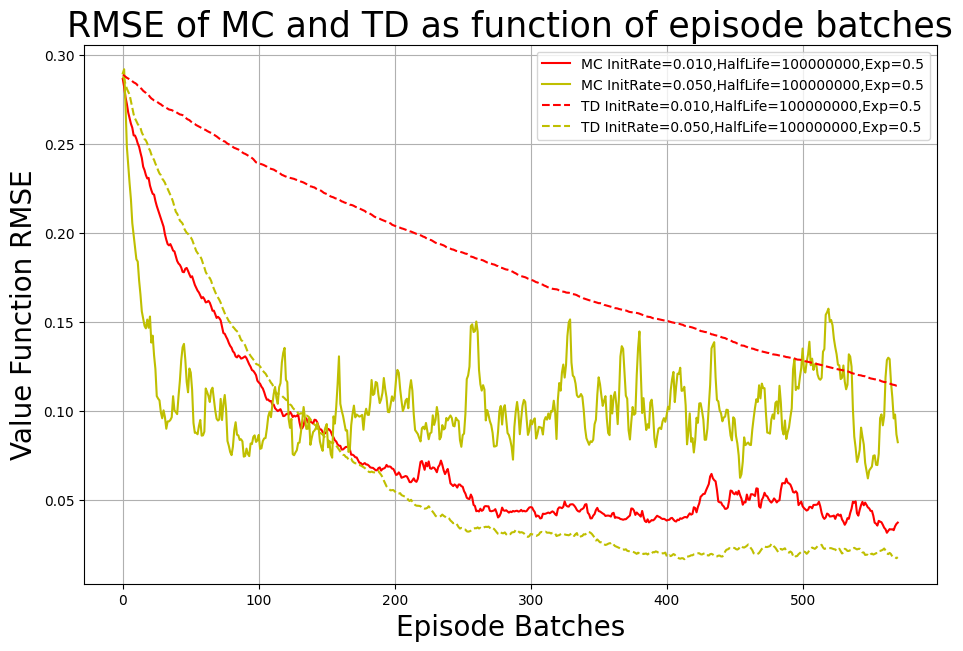

In [18]:
this_barrier: int = 10
this_p: float = 0.5
random_walk: RandomWalkMRP2D = RandomWalkMRP2D(
    B_1=this_barrier,
    B_2=this_barrier,
    p_right=this_p,
    p_up=this_p
)
compare_td_and_mc(
    fmrp=random_walk,
    gamma=1.0,
    mc_episode_length_tol=1e-6,
    num_episodes=4000,
    learning_rates=[(0.01, 1e8, 0.5), (0.05, 1e8, 0.5)],
    initial_vf_dict={s: 0.5 for s in random_walk.non_terminal_states},
    plot_batch=7,
    plot_start=0
)

## Question 2
In this question, we will explore three different algorithms for control
based on MC or TD. Please complete 2 of the following 3 implementations.
For each algorithm, we expect you to test your implementation against
the Optimal Value Function/Optimal Policy obtained by DP on
`SimpleInventoryMDPCap` in
[rl/chapter3/simple_inventory_mdp_cap.py](https://github.com/TikhonJelvis/RL-book/blob/master/rl/chapter3/simple_inventory_mdp_cap.py).
Then, generalize to MC Control with Function approximation and test your
implementation against the Optimal Value Function/Optimal Policy
obtained by ADP on `AssetAllocDiscrete` in
[rl/chapter7/asset_alloc_discrete.py](https://github.com/TikhonJelvis/RL-book/blob/master/rl/chapter7/asset_alloc_discrete.py).

1.  Implement Tabular Monte-Carlo Control algorithm in Python with GLIE
    implemented as $\epsilon = \frac 1 k$ for episode number $k$ and
    initial state of each episode sampled uniformly from the state
    space.

2.  Implement Tabular SARSA algorithm in Python with GLIE and a
    parameterized trajectory of decreasing step sizes.

3.  Implement Tabular Q-Learning algorithm in Python with infinite
    exploration of all (state, action) pairs and with a parameterized
    trajectory of decreasing step sizes.

## Question 3
Finally, we will explore reinforcment learning algorithms and apply them
to the problem of Amercian options pricing. Implement the following two
algorithms and apply them to the problem of American Options Pricing, as
covered in class. Test by comparing the pricing of American Calls and
Puts against the Binomial Tree implmeentation in
[rl/chapter8/optimal_exercise_bin_tree.py](https://github.com/TikhonJelvis/RL-book/blob/master/rl/chapter8/optimal_exercise_bin_tree.py).

1.  LSPI

2.  Deep Q-Learning